# Tech Challenge – FIAP (Fase 4)  
## LSTM para prever **fechamento** da ação do Itaú (**ITUB4.SA**) usando `yfinance`

- Coleta de dados com **yfinance**
- Feature engineering (médias móveis, retornos, volatilidade, RSI)
- Preparação de janelas (lookback) para LSTM
- Split temporal: treino / validação / teste (sem *shuffle*)
- Métricas: **MAE, RMSE, MAPE**
- Salvamento do modelo e do scaler (para deploy em API)



In [2]:
# Instalar dependências no seu ambiente:
# !pip install yfinance tensorflow scikit-learn pandas numpy matplotlib


In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras


In [4]:
from src.data_loader import fetch_yahoo_prices

df = fetch_yahoo_prices(
    "ITUB4.SA",
    start="2021-01-01",
    interval="1d"
)

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-08 13:00:00,24.713150,24.889673,24.280670,24.324800,17.722696,32786187
2021-02-09 13:00:00,24.263018,25.075022,24.033539,24.616062,17.934912,42778341
2021-02-10 13:00:00,24.624889,24.880848,24.165932,24.439541,17.806290,32474159
2021-02-11 13:00:00,24.704325,24.827890,24.271845,24.439541,17.806290,25381012
2021-02-12 22:05:00,24.298323,24.801413,24.183582,24.501324,17.851315,28173404


In [5]:
'''# 1) Coleta de dados (yfinance)
TICKER = "ITUB4.SA"
START = "2024-01-01"
END = None         # None = até hoje
INTERVAL = "1d"    # diário

df = yf.download(TICKER, start=START, end=END, interval=INTERVAL, auto_adjust=False, progress=False)
if df is None or df.empty:
    raise ValueError(f"Nenhum dado retornado para {TICKER}. Verifique ticker/período.")
df = df.dropna()
df.head()
'''

'# 1) Coleta de dados (yfinance)\nTICKER = "ITUB4.SA"\nSTART = "2024-01-01"\nEND = None         # None = até hoje\nINTERVAL = "1d"    # diário\n\ndf = yf.download(TICKER, start=START, end=END, interval=INTERVAL, auto_adjust=False, progress=False)\nif df is None or df.empty:\n    raise ValueError(f"Nenhum dado retornado para {TICKER}. Verifique ticker/período.")\ndf = df.dropna()\ndf.head()\n'

In [8]:
# 2) Feature engineering (adaptado para prever RETORNO)

import pandas as pd

def rsi_wilder(close: pd.Series, period: int = 14) -> pd.Series:
    """
    Calcula o RSI (Relative Strength Index) utilizando o método de Wilder.
    Retorna valores no intervalo [0, 100].
    """
    delta = close.diff()
    gain = delta.clip(lower=0)
    loss = (-delta).clip(lower=0)

    # Wilder smoothing (EMA com alpha = 1/period)
    avg_gain = gain.ewm(alpha=1 / period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1 / period, adjust=False).mean()

    rs = avg_gain / (avg_loss + 1e-12)
    return 100 - (100 / (1 + rs))


# Cria um DataFrame de features a partir do DataFrame original (mantém df intacto)
feat = df.copy()

# =========================
# Features baseadas em preço
# =========================

# Médias móveis simples (SMA)
feat["avg_last_21"] = feat["Adj Close"].rolling(window=21).mean()
feat["avg_last_9"]  = feat["Adj Close"].rolling(window=9).mean()

# Retorno simples diário em % (do dia t em relação ao t-1)
feat["simple_returns"] = feat["Adj Close"].pct_change() * 100.0

# Volatilidade dos retornos (em %)
feat["std_last_20_returns"] = feat["simple_returns"].rolling(window=20).std()
feat["std_last_5_returns"]  = feat["simple_returns"].rolling(window=5).std()

# Volatilidade do volume
feat["std_last_5_volume"] = feat["Volume"].rolling(window=5).std()

# RSI (momentum)
feat["rsi"] = rsi_wilder(feat["Adj Close"], period=14)

# =========================
# Target: RETORNO do próximo dia (t+1)
# =========================

# Guarda o close do dia t (pode ser útil depois na inferência para reconstruir preço)
feat["close_t"] = feat["Adj Close"]

# Retorno do próximo dia (t+1) em relação ao dia t:
# y_next_return = (P_{t+1} / P_t - 1)
feat["y_next_return"] = feat["Adj Close"].shift(-1) / feat["Adj Close"] - 1.0

# Retorno % 
feat["y_next_return_pct"] = feat["y_next_return"] * 100.0

# Remove NaNs gerados por rolling/pct_change/shift
feat = feat.dropna().copy()

# Visualiza as últimas linhas para validar features e target
feat.tail()


,Open,High,Low,Close,Adj Close,Volume,avg_last_21,avg_last_9,simple_returns,std_last_20_returns,std_last_5_returns,std_last_5_volume,rsi,close_t,y_next_return,y_next_return_pct
Date,,,,,,,,,,,,,,,,
2026-01-30 13:00:00,46.090000,46.380001,44.980000,45.500000,45.481819,38117000,41.459141,43.949098,-1.408455,1.601278,1.740438,5.772501e+06,76.380255,45.481819,0.008755,0.875475
2026-02-02 13:00:00,45.790001,46.099998,45.430000,45.880001,45.880001,28095400,41.780362,44.613093,0.875475,1.593364,1.722924,4.617690e+06,77.585274,45.880001,0.005667,0.566692
2026-02-03 13:00:00,46.299999,46.980000,45.889999,46.139999,46.139999,48570600,42.086832,45.111610,0.566692,1.593551,1.378611,7.319312e+06,78.361554,46.139999,-0.032943,-3.294323
2026-02-04 13:00:00,45.900002,45.980000,44.049999,44.619999,44.619999,48683500,42.309497,45.284634,-3.294323,1.760426,1.687996,8.777101e+06,64.333960,44.619999,0.020170,2.017036
2026-02-05 13:00:00,45.240002,45.880001,44.740002,45.520000,45.520000,36014400,42.605483,45.503235,2.017036,1.775974,2.102560,8.802765e+06,67.988029,45.520000,0.025703,2.570295


In [9]:
# 3) Definição de X e y (regressão) — agora prevendo RETORNO (%)

FEATURE_COLS = [
    "Adj Close",
    "Volume",
    "simple_returns",
    "std_last_5_returns",
    "std_last_20_returns",
    "avg_last_9",
    "avg_last_21",
    "rsi"
]

# X = features (entrada do modelo)
X = feat[FEATURE_COLS].values.astype("float32")

# y = target (retorno do próximo dia em %)
# Certifique-se de que você criou anteriormente:
# feat["y_next_return_pct"] = (feat["Adj Close"].shift(-1) / feat["Adj Close"] - 1.0) * 100.0
y = feat[["y_next_return_pct"]].values.astype("float32")  # (N,1)

len(X), X.shape, y.shape


(1227, (1227, 8), (1227, 1))

In [10]:
# 4) Split temporal + normalização (ajuste feito APENAS no conjunto de treino)

def temporal_split(X, y, train_ratio=0.70, val_ratio=0.15):
    """
    Realiza a divisão temporal dos dados em treino, validação e teste,
    preservando a ordem cronológica da série temporal.

    Parâmetros
    ----------
    X : array-like
        Matriz de features ordenadas no tempo (do passado para o futuro).
    y : array-like
        Vetor de targets correspondentes às features.
    train_ratio : float, opcional
        Proporção dos dados destinada ao conjunto de treino.
    val_ratio : float, opcional
        Proporção dos dados destinada ao conjunto de validação.

    Retorno
    -------
    (X_train, y_train), (X_val, y_val), (X_test, y_test)
        Tuplas contendo os conjuntos de treino, validação e teste.
    """

    # Número total de amostras
    n = len(X)

    # Tamanho do conjunto de treino
    n_train = int(n * train_ratio)

    # Tamanho do conjunto de validação
    n_val = int(n * val_ratio)

    # Conjunto de treino: dados mais antigos
    X_train, y_train = X[:n_train], y[:n_train]

    # Conjunto de validação: dados imediatamente após o treino
    X_val, y_val = X[n_train:n_train + n_val], y[n_train:n_train + n_val]

    # Conjunto de teste: dados mais recentes (nunca vistos pelo modelo)
    X_test, y_test = X[n_train + n_val:], y[n_train + n_val:]

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)


# Aplica o split temporal aos dados
(X_train, y_train), (X_val, y_val), (X_test, y_test) = temporal_split(X, y)

# Inicializa os normalizadores Min-Max para features (X) e target (y)
# Cada scaler será ajustado SOMENTE com os dados de treino
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# Normalização das features:
# - fit_transform apenas no treino (evita vazamento de informação)
# - transform nos conjuntos de validação e teste
X_train_s = x_scaler.fit_transform(X_train)
X_val_s   = x_scaler.transform(X_val)
X_test_s  = x_scaler.transform(X_test)

# Normalização do target:
# - fit_transform apenas no treino
# - transform nos demais conjuntos
y_train_s = y_scaler.fit_transform(y_train)
y_val_s   = y_scaler.transform(y_val)
y_test_s  = y_scaler.transform(y_test)

# Exibe as dimensões dos dados normalizados de treino
X_train_s.shape, y_train_s.shape


((858, 8), (858, 1))

In [11]:
print("y_train raw min/max:", float(y_train.min()), float(y_train.max()))
print("y_train_s min/max:", float(y_train_s.min()), float(y_train_s.max()))
print("y_scaler min/max:", y_scaler.data_min_, y_scaler.data_max_)


y_train raw min/max: -17.964277267456055 8.26888656616211
y_train_s min/max: 0.0 1.0
y_scaler min/max: [-17.964277] [8.268887]


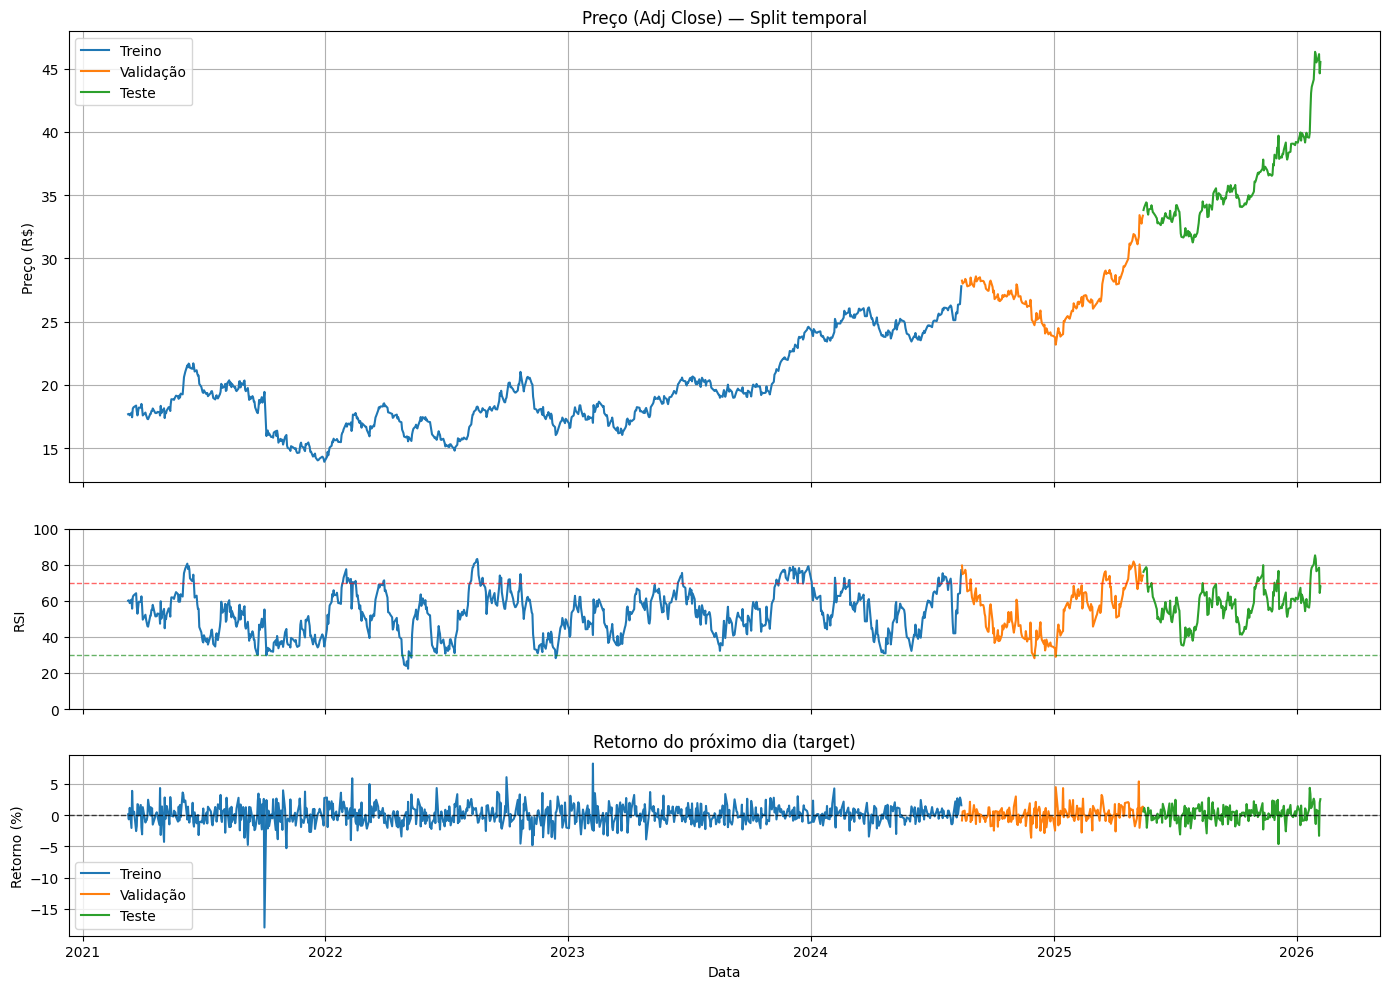

In [13]:
import matplotlib.pyplot as plt

# =========================
# Séries RAW (visualização)
# =========================
price_series = feat["Adj Close"].copy()
rsi_series   = feat["rsi"].copy()
ret_series   = feat["y_next_return_pct"].copy()

# =========================
# Split temporal
# =========================
n = len(feat)
n_train = int(n * 0.70)
n_val   = int(n * 0.15)

idx_train = feat.index[:n_train]
idx_val   = feat.index[n_train:n_train + n_val]
idx_test  = feat.index[n_train + n_val:]

# =========================
# Figura com 3 subplots
# =========================
fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1, figsize=(14, 10), sharex=True,
    gridspec_kw={"height_ratios": [3, 1.2, 1.2]}
)

# =========================
# Gráfico 1: Preço (Adj Close)
# =========================
ax1.plot(idx_train, price_series.loc[idx_train], label="Treino", color="tab:blue")
ax1.plot(idx_val,   price_series.loc[idx_val],   label="Validação", color="tab:orange")
ax1.plot(idx_test,  price_series.loc[idx_test],  label="Teste", color="tab:green")

ax1.set_title("Preço (Adj Close) — Split temporal")
ax1.set_ylabel("Preço (R$)")
ax1.legend()
ax1.grid(True)

# =========================
# Gráfico 2: RSI (período completo)
# =========================
ax2.plot(idx_train, rsi_series.loc[idx_train], color="tab:blue")
ax2.plot(idx_val,   rsi_series.loc[idx_val],   color="tab:orange")
ax2.plot(idx_test,  rsi_series.loc[idx_test],  color="tab:green")

ax2.axhline(70, linestyle="--", linewidth=1, color="red", alpha=0.6)
ax2.axhline(30, linestyle="--", linewidth=1, color="green", alpha=0.6)

ax2.set_ylabel("RSI")
ax2.set_ylim(0, 100)
ax2.grid(True)

# =========================
# Gráfico 3: Retorno alvo (y_next_return_pct)
# =========================
ax3.plot(idx_train, ret_series.loc[idx_train], label="Treino", color="tab:blue")
ax3.plot(idx_val,   ret_series.loc[idx_val],   label="Validação", color="tab:orange")
ax3.plot(idx_test,  ret_series.loc[idx_test],  label="Teste", color="tab:green")

ax3.axhline(0, linestyle="--", linewidth=1, color="black", alpha=0.7)

ax3.set_title("Retorno do próximo dia (target)")
ax3.set_ylabel("Retorno (%)")
ax3.set_xlabel("Data")
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()


In [14]:
# 5) Criação de janelas (lookback) para LSTM
def make_windows(X_scaled, y_scaled, lookback: int, name: str = ""):
    """
    Cria janelas temporais (sliding windows) para treinamento de modelos LSTM.

    Espera receber X_scaled e y_scaled já NORMALIZADOS (ex.: MinMaxScaler).
    """

    # Converte para numpy
    X_scaled = np.asarray(X_scaled, dtype=np.float32)
    y_scaled = np.asarray(y_scaled, dtype=np.float32)

    # Garante y em formato (n, 1)
    if y_scaled.ndim == 1:
        y_scaled = y_scaled.reshape(-1, 1)

    # Valida shapes
    if X_scaled.ndim != 2:
        raise ValueError(f"{name}X_scaled deve ser 2D (n_amostras, n_features). Shape: {X_scaled.shape}")
    if y_scaled.ndim != 2 or y_scaled.shape[1] != 1:
        raise ValueError(f"{name}y_scaled deve ser 2D (n_amostras, 1). Shape: {y_scaled.shape}")
    if len(X_scaled) != len(y_scaled):
        raise ValueError(f"{name}X e y devem ter o mesmo tamanho. X={len(X_scaled)} y={len(y_scaled)}")
        
    # (em MinMaxScaler, normalmente fica em ~0–1, podendo exceder 1 no teste)
    if y_scaled.max() > 5 or y_scaled.min() < -1:
        raise ValueError(
            f"{name}y_scaled parece NÃO normalizado (min={y_scaled.min():.3f}, max={y_scaled.max():.3f}). "
            "Você provavelmente passou y_test em vez de y_test_s."
        )

    Xw, yw = [], []

    # Cria janelas
    for i in range(lookback, len(X_scaled)):
        Xw.append(X_scaled[i - lookback:i, :])  # (lookback, n_features)
        yw.append(y_scaled[i, 0])               # escalar

    Xw = np.array(Xw, dtype=np.float32)
    yw = np.array(yw, dtype=np.float32).reshape(-1, 1)

    return Xw, yw


# Tamanho da janela temporal (lookback)
LOOKBACK = 10

# Criação das janelas para treino, validação e teste (IMPORTANTE: sempre usar *_s)
Xtr, ytr = make_windows(X_train_s, y_train_s, LOOKBACK, name="train_")
Xva, yva = make_windows(X_val_s,   y_val_s,   LOOKBACK, name="val_")
Xte, yte = make_windows(X_test_s,  y_test_s,  LOOKBACK, name="test_")

# Verifica shapes finais
print("Xtr:", Xtr.shape, "ytr:", ytr.shape)
print("Xva:", Xva.shape, "yva:", yva.shape)
print("Xte:", Xte.shape, "yte:", yte.shape)

# Verifica ranges (devem estar próximos de 0-1; teste pode exceder 1)
print("ytr min/max:", float(ytr.min()), float(ytr.max()))
print("yte min/max:", float(yte.min()), float(yte.max()))


Xtr: (848, 10, 8) ytr: (848, 1)
Xva: (174, 10, 8) yva: (174, 1)
Xte: (175, 10, 8) yte: (175, 1)
ytr min/max: 0.0 1.0
yte min/max: 0.5085573196411133 0.8519006371498108


In [15]:
# 5) Criação de janelas (lookback) para LSTM
def make_windows(X_scaled, y_scaled, lookback: int):
    """
    Cria janelas temporais (sliding windows) para treinamento de modelos LSTM.

    Parâmetros
    ----------
    X_scaled : array-like (numpy array ou pandas DataFrame)
        Features já normalizadas, no formato (n_amostras, n_features).
    y_scaled : array-like (numpy array ou pandas Series/DataFrame)
        Target já normalizado, no formato (n_amostras,) ou (n_amostras, 1).
    lookback : int
        Número de passos temporais anteriores utilizados como entrada.

    Retorno
    -------
    Xw : np.ndarray
        Array 3D no formato (n_janelas, lookback, n_features),
        compatível com entrada de LSTM.
    yw : np.ndarray
        Array 2D no formato (n_janelas, 1), correspondente ao target futuro.
    """

    # Garante que X e y sejam numpy arrays
    X_scaled = np.asarray(X_scaled, dtype=np.float32)
    y_scaled = np.asarray(y_scaled, dtype=np.float32)

    # Garante que y tenha shape (n, 1)
    if y_scaled.ndim == 1:
        y_scaled = y_scaled.reshape(-1, 1)

    Xw, yw = [], []

    # Criação das janelas temporais
    for i in range(lookback, len(X_scaled)):
        # Janela de entrada: dados do tempo (i-lookback) até (i-1)
        Xw.append(X_scaled[i - lookback:i, :])

        # Target associado: valor do tempo i
        yw.append(y_scaled[i, 0])

    # Converte listas em arrays numpy
    Xw = np.array(Xw, dtype=np.float32)
    yw = np.array(yw, dtype=np.float32).reshape(-1, 1)

    return Xw, yw


# Tamanho da janela temporal (lookback)
LOOKBACK = 10

# Criação das janelas para treino, validação e teste
Xtr, ytr = make_windows(X_train_s, y_train_s, LOOKBACK)
Xva, yva = make_windows(X_val_s,   y_val_s,   LOOKBACK)
Xte, yte = make_windows(X_test_s,  y_test_s,  LOOKBACK)

# Verifica shapes finais
Xtr.shape, ytr.shape, Xte.shape


((848, 10, 8), (848, 1), (175, 10, 8))

In [16]:
# 6) Modelo LSTM (regressão para previsão de preço)

# Número de features de entrada (ex.: médias móveis, RSI, volatilidade, etc.)
# Corresponde à terceira dimensão do tensor Xtr: (amostras, lookback, features)
n_features = Xtr.shape[2]

# Define um modelo sequencial de redes neurais recorrentes (LSTM)
model = keras.Sequential([
    # Camada de entrada:
    # recebe sequências temporais com comprimento LOOKBACK
    # e n_features variáveis em cada passo de tempo
    keras.layers.Input(shape=(LOOKBACK, n_features)),

    # Primeira camada LSTM com 64 unidades
    # return_sequences=True permite que a saída seja uma sequência,
    # necessária para empilhar outra camada LSTM em seguida
    keras.layers.LSTM(64, return_sequences=True),

    # Dropout para reduzir overfitting
    # desativa aleatoriamente 20% das unidades durante o treino
    keras.layers.Dropout(0.1),

    # Segunda camada LSTM com 32 unidades
    # return_sequences=False (padrão), retornando apenas o último estado,
    # que resume a informação temporal da sequência inteira
    keras.layers.LSTM(32),

    # Dropout adicional para regularização
    keras.layers.Dropout(0.1),

    # Camada densa final com 1 neurônio:
    # saída contínua correspondente ao preço de fechamento previsto (regressão)
    keras.layers.Dense(1)
])

# Compila o modelo:
# - Otimizador Adam com taxa de aprendizado 0.001
# - Função de perda MSE (Mean Squared Error), adequada para regressão
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=2e-3),
    loss="mse"
)

# Exibe um resumo da arquitetura do modelo
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 64)              │          18,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,137 (121.63 KB)

 Trainable params: 31,137 (121.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0926 - val_loss: 0.0102 - learning_rate: 0.0020
Epoch 2/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0105 - val_loss: 0.0054 - learning_rate: 0.0020
Epoch 3/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0089 - val_loss: 0.0030 - learning_rate: 0.0020
Epoch 4/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0084 - val_loss: 0.0028 - learning_rate: 0.0020
Epoch 5/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0073 - val_loss: 0.0032 - learning_rate: 0.0020
Epoch 6/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0074 - val_loss: 0.0029 - learning_rate: 0.0020
Epoch 7/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0068 - val_loss: 0.0028 - learning_rate: 0.0020
Epoch 8/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0068 - val_loss: 0.0034 - learning_rate: 0.0020
Epoch 9/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0066 - val_loss: 0.0039 - learning_rate: 0.0020
Epoch 10/80
27/27 ━

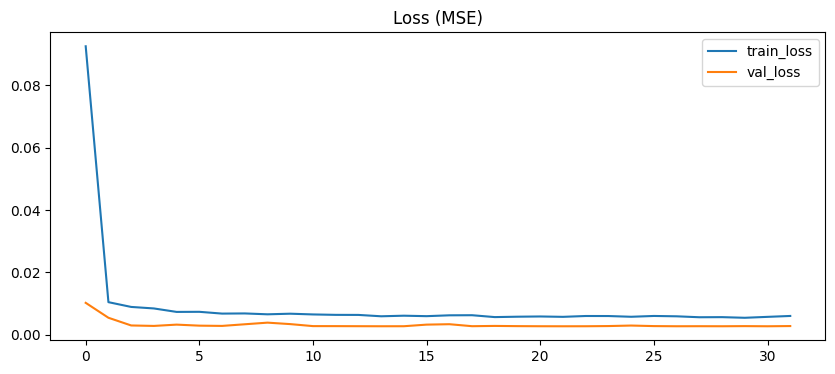

In [17]:
# 7) Treinamento
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5),
]

history = model.fit(
    Xtr, ytr,
    validation_data=(Xva, yva),
    epochs=80,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

plt.figure(figsize=(10,4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss (MSE)")
plt.show()


MAE (p.p.): 0.9803184270858765
RMSE (p.p.): 1.2917966842651367
MAPE (%): 670601052160.0 %


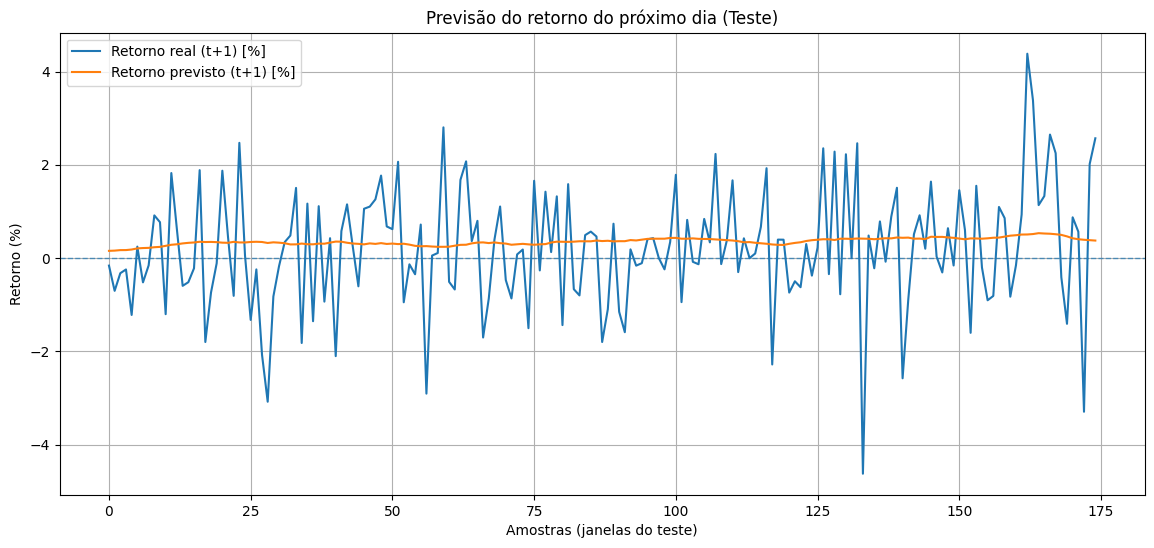

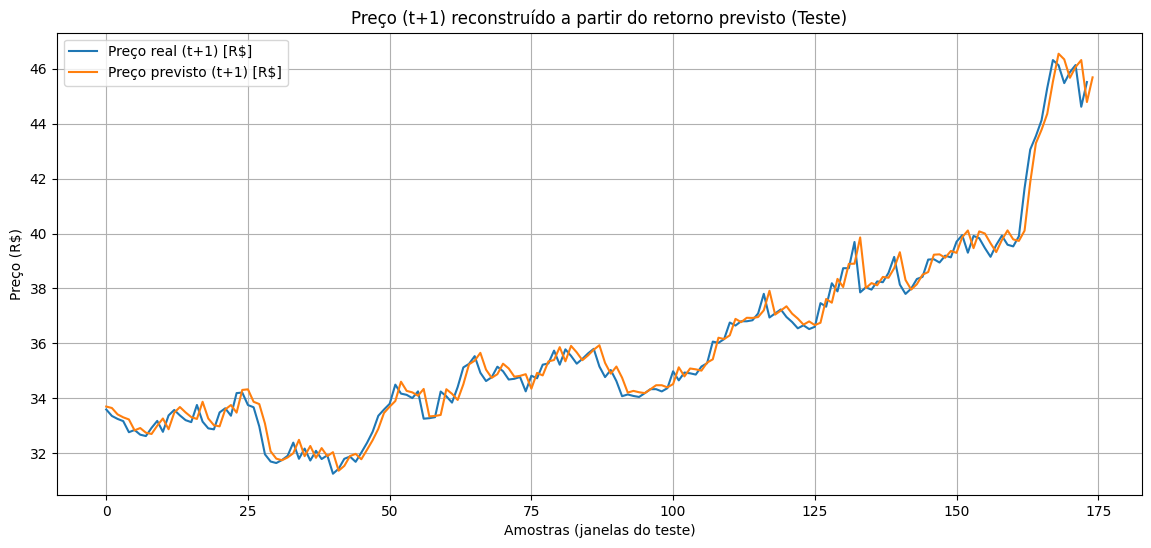

In [21]:
# 9) Gráfico Real vs Previsto (teste)

LOOKBACK = 10  # seu lookback atual

# =========================
# Métricas
# =========================
def mae(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mape(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-12))) * 100


# =========================
# 1) Predição (scaled)
# =========================
y_pred_s = model.predict(Xte, verbose=0).astype("float32")

# =========================
# 2) Desnormaliza para retorno (%)
# =========================
y_true_ret_pct = y_scaler.inverse_transform(yte).reshape(-1)
y_pred_ret_pct = y_scaler.inverse_transform(y_pred_s).reshape(-1)

print("MAE (p.p.):", float(mae(y_true_ret_pct, y_pred_ret_pct)))
print("RMSE (p.p.):", float(rmse(y_true_ret_pct, y_pred_ret_pct)))
print("MAPE (%):", float(mape(y_true_ret_pct, y_pred_ret_pct)), "%")


# =========================
# 3) Gráfico: retorno real vs previsto (teste)
# =========================
plt.figure(figsize=(14, 6))
plt.plot(y_true_ret_pct, label="Retorno real (t+1) [%]")
plt.plot(y_pred_ret_pct, label="Retorno previsto (t+1) [%]")
plt.axhline(0, linestyle="--", linewidth=1, alpha=0.7)
plt.title("Previsão do retorno do próximo dia (Teste)")
plt.xlabel("Amostras (janelas do teste)")
plt.ylabel("Retorno (%)")
plt.legend()
plt.grid(True)
plt.show()


# =========================
# 4) Reconstrução do preço (t+1) para interpretação
#    Alinhamento EXATO com yte/y_pred_s:
#
# - Seu split temporal foi feito no nível de X/y (feat)
# - O conjunto de teste começa em test_start = n_train + n_val
# - Ao criar janelas com lookback, perdemos as primeiras LOOKBACK amostras do teste
# - Portanto, o índice em feat correspondente às previsões começa em:
#     pred_start = test_start + LOOKBACK
# =========================
n = len(feat)
n_train = int(n * 0.70)
n_val   = int(n * 0.15)
test_start = n_train + n_val
pred_start = test_start + LOOKBACK

# Índices exatos do feat que correspondem às previsões do teste
# i = pred_start ... n-1
# Para cada i:
# - P_t = Adj Close em i
# - retorno alvo é y_next_return_pct em i (retorno de i -> i+1)
# - preço real do próximo dia é Adj Close em i+1
idx_pred = feat.index[pred_start:]  # deve ter mesmo tamanho de y_true_ret_pct

# P_t (preço do "dia t" correspondente à linha do target)
price_t = feat.loc[idx_pred, "Adj Close"].values.reshape(-1)

# Preço real do próximo dia (t+1)
# pega Adj Close na posição seguinte (shift -1)
price_true_t1 = feat["Adj Close"].shift(-1).loc[idx_pred].values.reshape(-1)

# Preço previsto do próximo dia via retorno previsto
price_pred_t1 = price_t * (1.0 + (y_pred_ret_pct / 100.0))

# Sanidade: tamanhos devem ser iguais
assert len(price_true_t1) == len(price_pred_t1) == len(y_true_ret_pct), "Alinhamento inconsistente"

plt.figure(figsize=(14, 6))
plt.plot(price_true_t1, label="Preço real (t+1) [R$]")
plt.plot(price_pred_t1, label="Preço previsto (t+1) [R$]")
plt.title("Preço (t+1) reconstruído a partir do retorno previsto (Teste)")
plt.xlabel("Amostras (janelas do teste)")
plt.ylabel("Preço (R$)")
plt.legend()
plt.grid(True)
plt.show()


In [22]:
# 10) Salvamento (modelo + scalers) — MODELO DE RETORNO
import os, json

TICKER = "ITUB4.SA"
TARGET_TYPE = "return"  # apenas informativo

ARTIFACT_DIR = "artifacts_itub4_return"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# Salva o modelo
model_path = os.path.join(ARTIFACT_DIR, "best_model.keras")
model.save(model_path)

# Salva os scalers (necessários para inferência)
np.save(os.path.join(ARTIFACT_DIR, "x_scaler_min.npy"), x_scaler.min_)
np.save(os.path.join(ARTIFACT_DIR, "x_scaler_scale.npy"), x_scaler.scale_)

np.save(os.path.join(ARTIFACT_DIR, "y_scaler_min.npy"), y_scaler.min_)
np.save(os.path.join(ARTIFACT_DIR, "y_scaler_scale.npy"), y_scaler.scale_)

# Métricas (para retorno NÃO usar MAPE)
metrics = {
    "ticker": TICKER,
    "target": TARGET_TYPE,
    "lookback": int(LOOKBACK),
    "features": list(FEATURE_COLS),
    "MAE_pp": float(mae(y_true_ret_pct, y_pred_ret_pct)),
    "RMSE_pp": float(rmse(y_true_ret_pct, y_pred_ret_pct)),
}

with open(os.path.join(ARTIFACT_DIR, "metrics.json"), "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

print("Modelo de RETORNO salvo em:", ARTIFACT_DIR)
print(metrics)


Modelo de RETORNO salvo em: artifacts_itub4_return
{'ticker': 'ITUB4.SA', 'target': 'return', 'lookback': 10, 'features': ['Adj Close', 'Volume', 'simple_returns', 'std_last_5_returns', 'std_last_20_returns', 'avg_last_9', 'avg_last_21', 'rsi'], 'MAE_pp': 0.9803184270858765, 'RMSE_pp': 1.2917966842651367}


In [131]:
print("y_scaler min/max:", y_scaler.data_min_, y_scaler.data_max_)
print("yte scaled min/max:", yte.min(), yte.max())
print("y_pred_s min/max:", y_pred_s.min(), y_pred_s.max())
print("shapes:", yte.shape, y_pred_s.shape)


y_scaler min/max: [13.914319] [27.792536]
yte scaled min/max: 1.2493057 2.3351102
y_pred_s min/max: 1.1590028 1.5482423
shapes: (175, 1) (175, 1)
